In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage import io, img_as_ubyte
from skimage.morphology import binary_erosion, binary_dilation
import csv


In [2]:
output_dir = "./data/PML_bodies_annotations"
os.makedirs(output_dir, exist_ok=True)


In [3]:
count_csv_path = os.path.join(output_dir, "object_counts.csv")
with open(count_csv_path, "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["image_name", "object_count"])  # CSV header


In [13]:
#preprocessing steps
def preprocess_image(image):
    
#     if len(image.shape) == 3:
#         image = np.mean(image, axis = -1)
        
#     threshold_value = threshold_otsu(image)
#     binary_image = image > threshold_value
#     binary_image = img_as_ubyte(binary_image)
    
#     return binary_image

    image = cv2.imread(image_path)  # Read the image from the specified path
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)  # Apply Gaussian blur to reduce noise
    return blurred, image  # Return the processed mask and the original image

In [17]:
#refine mask
def refine_mask(mask):
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)  # Apply binary thresholding
    kernel = np.ones((3, 3), np.uint8)  # Create a kernel for morphological operations
    refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)  # Close small holes in the binary mask
    return refined_mask  # Return the refined binary mask
    
#     #This removes small noise in the binary image by eroding (shrinking) the shapes.
#     eroded_image = binary_erosion(binary_image) 
    
#     #This restores the shapes of the remaining objects by dilating (expanding) the eroded image.
#     refined_image = binary_dilation(eroded_image)
#     return refined_image

In [19]:
def count_objects(refined_mask):
    
    labeled_mask = label(refined_mask)  # Label connected components in the mask
    num_objects = len(np.unique(labeled_mask)) - 1  # Count unique labels, excluding background
    return num_objects, labeled_mask  # Return the count and the labeled mask
    
#     #This labels connected regions (dots) in the binary image, giving each dot a unique label.
#     labeled_image = label(binary_image)
    
#     #This gets properties of the labeled regions, such as area and bounding boxes.
#     regions = regionprops(labeled_image)
#     return len(regions), labeled_image, regions


In [15]:
# def annotate_image(image_path, output_dir):
#     image = io.imread(image_path)
#     binary_image = preprocess_image(image)
#     refined_binary_image = refine_mask(binary_image)
#     num_dots, labeled_image, regions = count_objects(refined_binary_image)
#     mask_output_path = os.path.join(output_dir, f"mask_{os.path.basename(image_path)}")
#     cv2.imwrite(mask_output_path, labeled_image.astype(np.uint8) * 255)

#     bbox_output_path = os.path.join(output_dir, "bounding_boxes.csv")
#     with open(bbox_output_path, "a") as f:
#         for region in regions:
#             min_row, min_col, max_row, max_col = region.bbox
#             f.write(f"{os.path.basename(image_path)},{min_row},{min_col},{max_row},{max_col}\n")

#     with open(count_csv_path, "a", newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow([os.path.basename(image_path), num_dots])

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.imshow(image, cmap='gray')
#     plt.title("Original Image")

#     plt.subplot(1, 2, 2)
#     plt.imshow(labeled_image, cmap="nipy_spectral")
#     plt.title(f"Annotated Mask: {num_dots} Dots")
    
#     plt.show()

#     return num_dots

def annotate_image(image_path, output_dir):
    mask, original_image = preprocess_image(image_path)  # Preprocess the image
    refined_mask = refine_mask(mask)  # Refine the mask
    num_dots, labeled_mask = count_objects(refined_mask)  # Count objects

    # Draw bounding boxes on the original image
    for region in regionprops(labeled_mask):  # Iterate over detected regions
        minr, minc, maxr, maxc = region.bbox  # Get bounding box coordinates
        cv2.rectangle(original_image, (minc, minr), (maxc, maxr), (255, 0, 0), 2)  # Draw rectangle

    # Show original and annotated images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)  # Create a subplot for the original image
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Display the original image
    
    plt.subplot(1, 2, 2)  # Create a subplot for the annotated image
    plt.title("Annotated Image")
    plt.imshow(refined_mask, cmap='gray')  # Display the refined mask
    
    plt.show()  # Show the plots

    # Save the annotated output
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    output_image_path = os.path.join(output_dir, 'annotated_image.png')  # Path for saving the annotated image
    cv2.imwrite(output_image_path, original_image)  # Save the annotated image
    
    # Log the count of objects
    object_counts = {'image_name': os.path.basename(image_path), 'count': num_dots}  # Create a dictionary to log counts
    return num_dots  # Return the number of detected dots



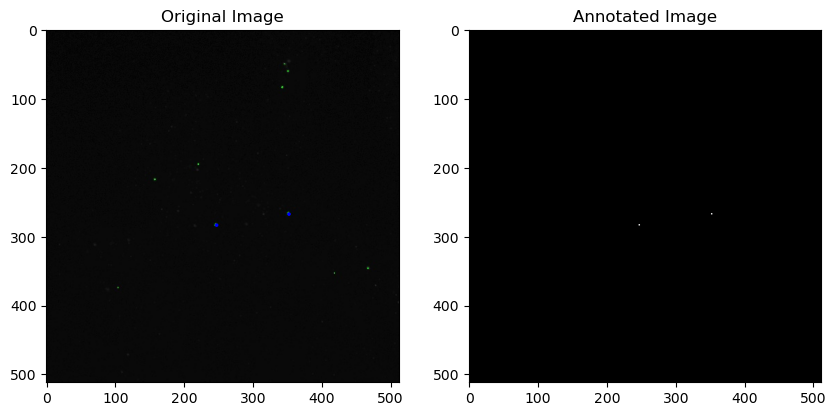

Total dots detected in the image: 2


In [20]:
# Set the output directory for saving results
output_dir = "./data/PML_bodies_annotations"

# Path to the image you want to annotate (change this to your image path)
image_path = "./data/PMLbodies/transformed_pml - Position 1_Z00_C1.jpg"  # Change this to your image path

# Run the annotation function for the specified image
num_dots = annotate_image(image_path, output_dir)

print(f"Total dots detected in the image: {num_dots}")

Number of PML bodies (white-circled): 50


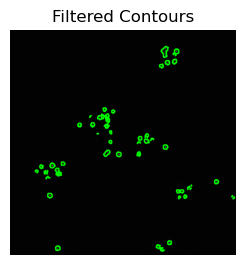

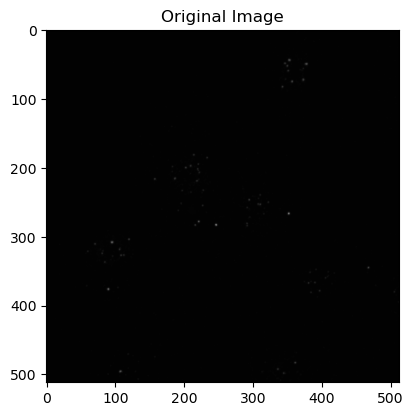

In [48]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('/Users/pallavisingh/Library/CloudStorage/OneDrive-DalhousieUniversity/MLOPs Project/merged_image.tif')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, 
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY_INV, 
                                        11, 2)

# Find contours
contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize list to hold valid contours (white-circled bodies)
valid_contours = []

# Filter contours based on area (size threshold)
min_area = 0.5   # Minimum contour area (adjust based on your image)
max_area = 215 # Maximum contour area (adjust as needed)

for contour in contours:
    area = cv2.contourArea(contour)
    if min_area < area < max_area:
        valid_contours.append(contour)

# Draw filtered contours (white-circled bodies) on the original image
result_image = image.copy()
cv2.drawContours(result_image, valid_contours, -1, (0, 255, 0), 2)
# Convert the image from BGR (OpenCV default) to RGB for proper display in matplotlib
adaptive_thresh_rgb = cv2.cvtColor(adaptive_thresh, cv2.COLOR_GRAY2RGB)
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
# Count the number of valid PML bodies (white-circled)
num_pml_bodies = len(valid_contours)

# Display the results
print(f'Number of PML bodies (white-circled): {num_pml_bodies}')
# Plot the filtered contours result
plt.subplot(1, 2, 2)
plt.imshow(result_image_rgb)
plt.title('Filtered Contours')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Create a subplot for the original image
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Display the original image

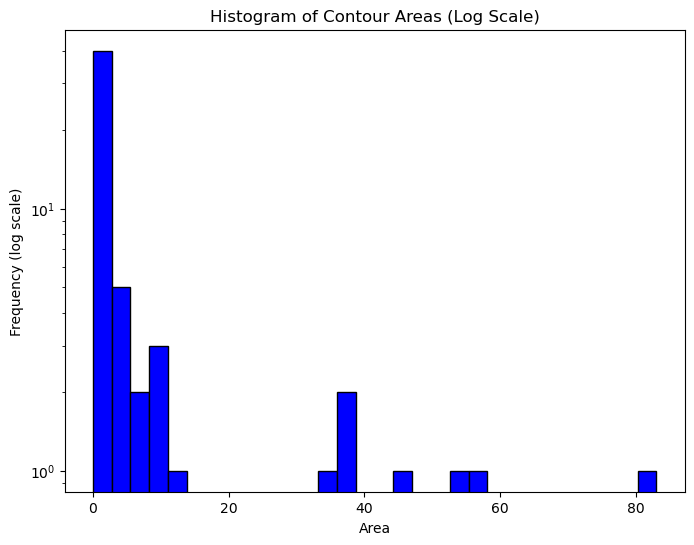

Min contour area: 0.0
Max contour area: 83.0
Sorted contour areas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 1.0, 1.0, 1.5, 1.5, 2.5, 2.5, 3.0, 3.0, 4.0, 4.5, 5.0, 6.0, 8.0, 9.0, 9.0, 11.0, 12.5, 35.0, 37.5, 38.0, 44.5, 53.0, 58.0, 83.0]


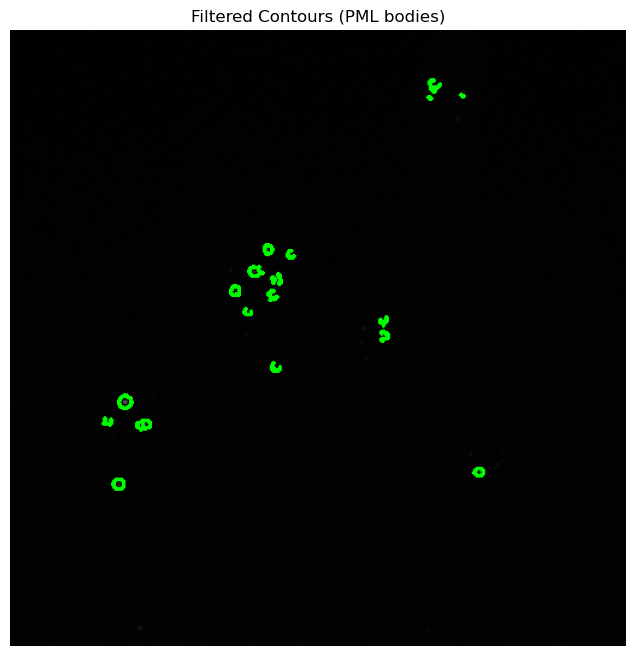

Number of PML bodies (white-circled): 22


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ensure plots are displayed in the notebook
%matplotlib inline

# Load the image
image = cv2.imread('/Users/pallavisingh/Library/CloudStorage/OneDrive-SharedLibraries-DalhousieUniversity/Priyadharshini Sridharan - MLOps images/SAEC exp1 As High 63x - Position 1_Z14_C1.tif')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, 
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY_INV, 
                                        11, 2)

# Find contours
contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate areas of all contours
areas = [cv2.contourArea(contour) for contour in contours]

# Plot histogram of contour areas in the notebook
# Plot histogram of contour areas with a log scale for the y-axis
plt.figure(figsize=(8,6))
plt.hist(areas, bins=30, color='blue', edgecolor='black')
plt.yscale('log')  # Set the y-axis to log scale
plt.title('Histogram of Contour Areas (Log Scale)')
plt.xlabel('Area')
plt.ylabel('Frequency (log scale)')
plt.show()
# plt.figure(figsize=(8,6))
# plt.hist(areas, bins=30, color='blue', edgecolor='black')
# plt.title('Histogram of Contour Areas')
# plt.xlabel('Area')
# plt.ylabel('Frequency')
# plt.show()

# Print the minimum and maximum area values for inspection
print(f"Min contour area: {min(areas)}")
print(f"Max contour area: {max(areas)}")

# Optional: print some specific areas to understand the range
print(f"Sorted contour areas: {sorted(areas)}")

# Manually adjust based on observation
min_area = 1   # Set after observing the histogram
max_area = 1000 # Set after observing the histogram

# Filter contours based on the area threshold
valid_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]

# Instead of displaying via OpenCV, display the filtered contours using matplotlib
result_image = image.copy()
cv2.drawContours(result_image, valid_contours, -1, (0, 255, 0), 2)

# Convert the BGR OpenCV image to RGB for displaying in matplotlib
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

# Plot the filtered contour image in the notebook


plt.figure(figsize=(8,8))
plt.imshow(result_image_rgb)
plt.title('Filtered Contours (PML bodies)')
plt.axis('off')
plt.show()

# Count the number of valid PML bodies (white-circled)
num_pml_bodies = len(valid_contours)
print(f'Number of PML bodies (white-circled): {num_pml_bodies}')


Image mode: RGB
Converted to grayscale: L (8-bit)


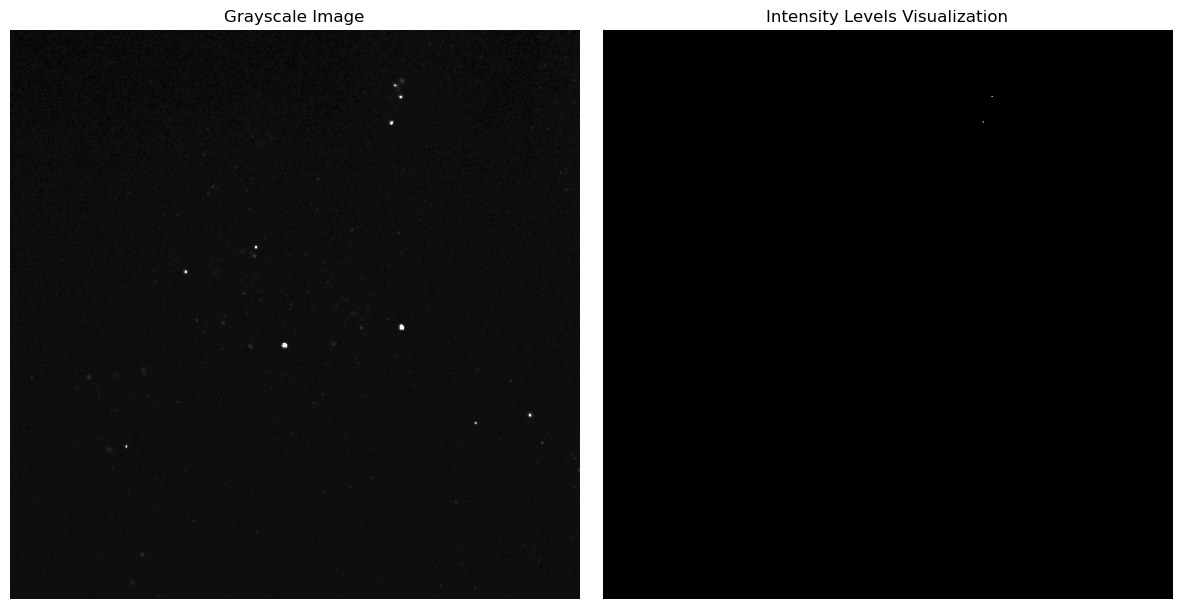

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# # Load the RGB image
# image_path = './your_rgb_image.jpg'  # Update this with your image path
image = Image.open(image_path)

# Check the mode of the image
image_mode = image.mode
print(f"Image mode: {image_mode}")

# Convert the image to grayscale
if image_mode == 'RGB':
    grayscale_image = image.convert('L')
else:
    grayscale_image = image

# Convert the grayscale image to a numpy array
grayscale_array = np.array(grayscale_image)

# Print out the bit depth of the grayscale image
print(f"Converted to grayscale: {grayscale_image.mode} (8-bit)")

# Function to visualize specific intensity levels
def visualize_intensity_levels(image_array, levels):
    # Create a mask for each level
    masks = {level: (image_array == level) for level in levels}
    
    # Create an empty image for visualization
    visualization = np.zeros_like(image_array)

    # Set pixels in the visualization image based on the masks
    for level in levels:
        visualization[masks[level]] = level  # Use the intensity level for visualization

    return visualization

# Define the intensity levels to visualize
intensity_levels = [0, 50, 128, 200, 255]

# Create a visualization for the specified intensity levels
visualization_image = visualize_intensity_levels(grayscale_array, intensity_levels)

# Convert the visualization to an image
visualization_pil = Image.fromarray(np.uint8(visualization_image))

# Plotting the original grayscale image and the visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_array, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(visualization_pil, cmap='gray')
plt.title('Intensity Levels Visualization')
plt.axis('off')

plt.tight_layout()
plt.show()


In [57]:
import cv2
import numpy as np

def count_particles(image_path, min_area=10, max_area=500):
    """
    Detect and count particles in microscopy images using adaptive thresholding
    and contour detection with area filtering.
    
    Parameters:
    image_path: str or numpy.ndarray
        Path to the image or image array
    min_area: int
        Minimum contour area to consider (filters noise)
    max_area: int
        Maximum contour area to consider (filters large artifacts)
    
    Returns:
    tuple: (processed_image, count, contours)
    """
    # Read image if path is provided, otherwise use the array
    if isinstance(image_path, str):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        image = image_path.copy()
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11,
        2
    )
    
    # Optional: Apply morphological operations to clean up the image
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(
        cleaned,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Filter contours based on area
    valid_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            valid_contours.append(contour)
    
    # Draw contours on original image for visualization
    result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(result, valid_contours, -1, (0, 255, 0), 2)
    
    # Add count text to image
    count = len(valid_contours)
    cv2.putText(
        result,
        f'Count: {count}',
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2
    )
    
    return result, count, valid_contours

def analyze_particle_stats(contours):
    """
    Analyze statistics of detected particles
    
    Parameters:
    contours: list
        List of contours from count_particles function
    
    Returns:
    dict: Statistical information about particles
    """
    areas = [cv2.contourArea(contour) for contour in contours]
    
    stats = {
        'count': len(contours),
        'mean_area': np.mean(areas) if areas else 0,
        'std_area': np.std(areas) if areas else 0,
        'min_area': min(areas) if areas else 0,
        'max_area': max(areas) if areas else 0
    }
    
    return stats

# Example usage:

# For a single image:
image_path = '/Users/pallavisingh/Library/CloudStorage/OneDrive-DalhousieUniversity/MLOPs Project/merged_image.tif'

result_image, count, contours = count_particles(image_path)
stats = analyze_particle_stats(contours)
result_image



11

In [58]:
stats

{'count': 11,
 'mean_area': 22.636363636363637,
 'std_area': 14.13263616451926,
 'min_area': 10.0,
 'max_area': 47.0}

In [71]:
import cv2
import numpy as np

def count_particles(image, min_area=3, max_area=1000, min_intensity=20, sensitivity=0.3):
    """
    Enhanced particle detection for fluorescent/bright dots with varying intensities.
    
    Parameters:
    image: numpy.ndarray
        Input image array
    min_area: int
        Minimum contour area to consider
    max_area: int
        Maximum contour area to consider
    min_intensity: int
        Minimum pixel intensity to consider (0-255)
    sensitivity: float
        Threshold sensitivity (0-1), lower values detect fainter dots
    
    Returns:
    tuple: (processed_image, count, contours)
    """
    # Ensure image is in correct format
    if len(image.shape) > 2:
        # Convert RGB/BGR to grayscale if needed
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 if not already
    if image.dtype != np.uint8:
        # Normalize to 0-255 range
        image = ((image - image.min()) * (255.0/(image.max() - image.min()))).astype(np.uint8)
    
    # Apply contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)
    
    # Apply mild denoising
    denoised = cv2.fastNlMeansDenoising(enhanced, None, h=10)
    
    # Apply threshold to detect bright spots
    binary = cv2.threshold(denoised, min_intensity, 255, cv2.THRESH_BINARY)[1]
    
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
    
    # Filter components based on area and create list of valid centroids
    valid_centroids = []
    for i in range(1, num_labels):  # Skip background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        if min_area <= area <= max_area:
            # Get the component mask
            component_mask = (labels == i).astype(np.uint8) * 255
            # Check mean intensity in original image
            mean_intensity = cv2.mean(image, mask=component_mask)[0]
            if mean_intensity >= min_intensity:
                valid_centroids.append((
                    int(centroids[i][0]),  # x
                    int(centroids[i][1])   # y
                ))
    
    # Create result image
    result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Draw detected points
    for centroid in valid_centroids:
        cv2.circle(result, centroid, 5, (0, 255, 0), -1)
    
    # Add count text
    count = len(valid_centroids)
    cv2.putText(
        result,
        f'Count: {count}',
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2
    )
    
    # Create contour objects for compatibility with stats function
    contours = []
    for centroid in valid_centroids:
        # Create a circle contour around each centroid
        circle_points = cv2.ellipse2Poly(
            (int(centroid[0]), int(centroid[1])),
            (3, 3),  # radius
            0, 0, 360, 10
        )
        contours.append(circle_points)
    
    return result, count, contours

def analyze_particle_stats(image, contours):
    """
    Analyze statistics of detected particles including intensity information
    
    Parameters:
    image: numpy.ndarray
        Original image
    contours: list
        List of contours
        
    Returns:
    dict: Statistical information about particles
    """
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    intensities = []
    positions = []
    
    for contour in contours:
        # Create mask for this contour
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.fillPoly(mask, [contour], 255)
        
        # Calculate centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            positions.append((cx, cy))
        
        # Calculate mean intensity
        mean_intensity = cv2.mean(image, mask=mask)[0]
        intensities.append(mean_intensity)
    
    stats = {
        'count': len(contours),
        'mean_intensity': np.mean(intensities) if intensities else 0,
        'std_intensity': np.std(intensities) if intensities else 0,
        'min_intensity': min(intensities) if intensities else 0,
        'max_intensity': max(intensities) if intensities else 0
    }
    
    return stats

# Example usage:

result_image, count, contours = count_particles(
    image,
    min_area=1,          # Minimum area to consider as a dot
    max_area=1000,       # Maximum area to consider
    min_intensity=20,    # Minimum brightness to consider
    sensitivity=0.3      # Lower value detects fainter dots
)
stats = analyze_particle_stats(image, contours)


In [72]:
stats

{'count': 15,
 'mean_intensity': 19.08566322419981,
 'std_intensity': 5.323549783001554,
 'min_intensity': 11.512195121951219,
 'max_intensity': 28.56756756756757}